# Iteratively creating training datasets across WA state using HUC boundaries and NWI polygons

In [1]:
library(terra)
library(sf)
library(tidyterra)
library(MultiscaleDTM)
library(randomForest)
library(caret)
library(vip)
library(rstac)

terra 1.7.71

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.0; sf_use_s2() is TRUE


Attaching package: ‘tidyterra’


The following object is masked from ‘package:stats’:

    filter


Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




In [5]:
wa_shp <- vect("data/wa_shp_diss.gpkg")
wa_hucs <- vect("data/Hydrography/WA_HUC8.gpkg")

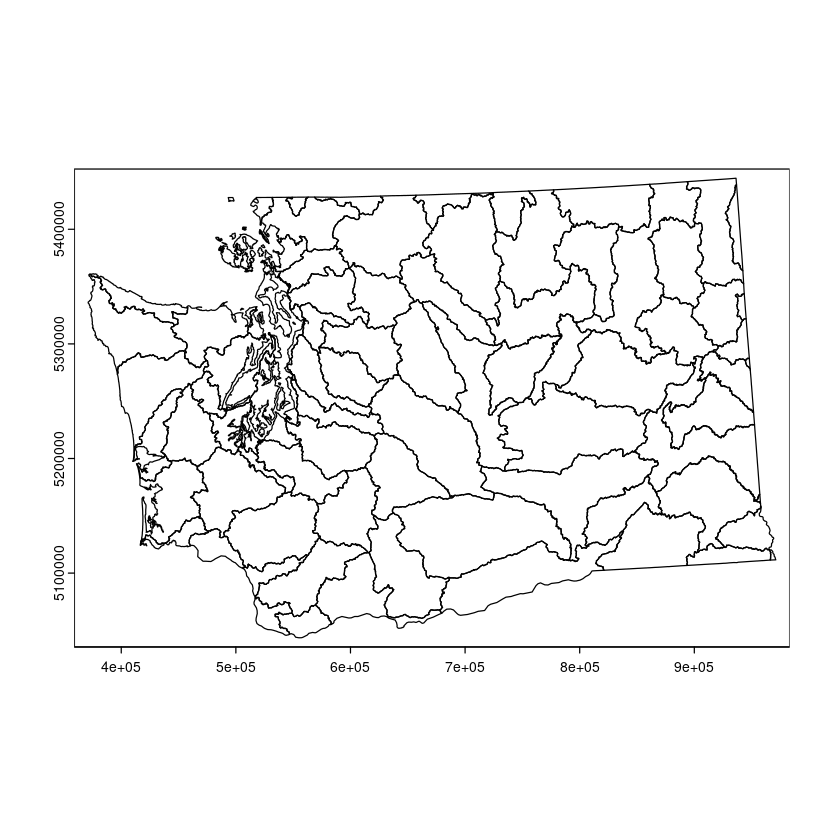

In [87]:
plot(wa_hucs, type = "classes")

In [64]:
WA_nwi <- vect("data/NWI_training_data/WA_Wetlands_filtered_noriv.gpkg")

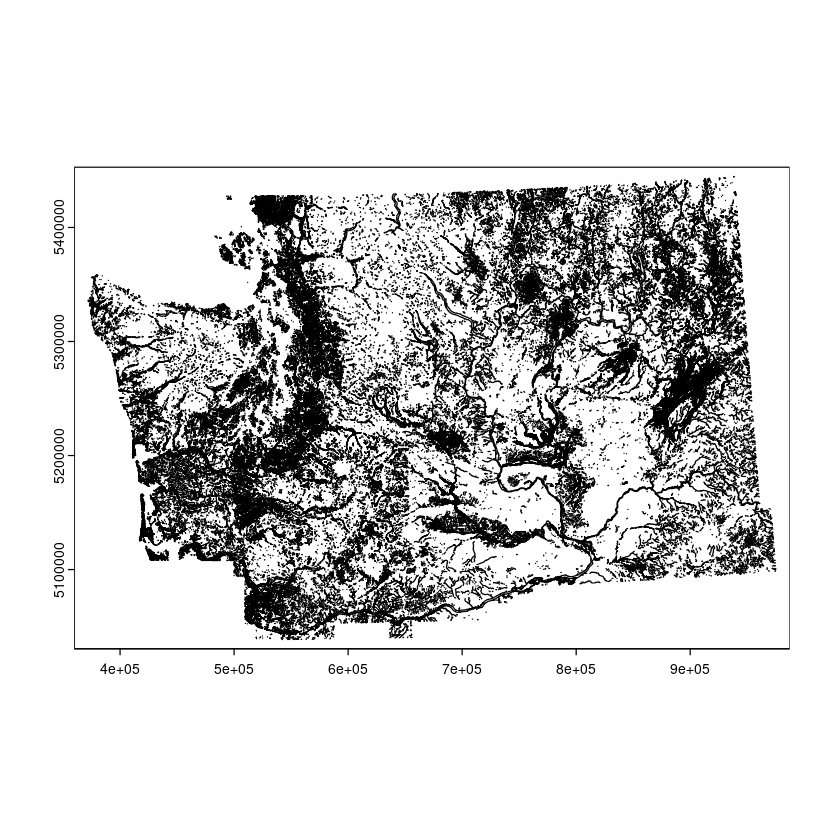

In [65]:
WA_nwi |> plot(type = "classes")

In [72]:
datapath <- paste0(getwd(), "/data/huc_data/points/")
datapath

[1] "/home/ajs0428/WIP Testing/data/huc_data/points/"

The Hoh was ~68,000ha and had 3-5,000 points derived which is a points:ha rat

In [13]:
5000/68000

[1] 0.07352941

For the size of one huc watershed in WA, we want 0.07pts per ha of surface area

In [16]:
round(terra::expanse(wa_hucs[1], unit = "ha")*0.07)

[1] 17375

Wetland and Upland points should be around 1:3 Wet/Upl ratio. 

In [22]:
round(terra::expanse(wa_hucs[1], unit = "ha")*0.07*.25) #Wetland points
round(terra::expanse(wa_hucs[1], unit = "ha")*0.07*.75) #Upland points

[1] 4344

[1] 13031

Function that iterates through all polygons in WA and

- Crops out NWI wetlands from larger WA file
- Calculates the area of the polygon
- Determines the number of WET/UPL points based on the area
- Splits total points by 1:3 WET/UPL ratio
- Generates UPL points using `spatSample` across whole polygon and inverse NWI mask
- Generates WET points using `spatSample` in only the NWI polygons
- combines both sample point datasets into one and writes out the save file as a gpkg


In [84]:
point_generator_func <- function(NWI, polygons, path) {
    for(i in 1:length(polygons)){
        nwicrp <- terra::crop(NWI, polygons[i])
        nwicrp_buff <- buffer(nwicrp, 30)
        area <- round(terra::expanse(polygons[i], unit = "ha"))
        numtot <- round(area*0.07)
        numwet <- round(0.25*numtot)
        numupl <- round(0.75*numtot)
        # print(area)
        # print(numtot)
        # print(numwet)
        # print(numupl)
        
        rand_upl <- spatSample(polygons[i], numupl) |>
                            terra::mask(nwicrp_buff, inverse = T) |> 
                            mutate(class = "UPL") |>
                            select(class)
        rand_wet <- spatSample(nwicrp, size = numwet) |> 
                            mutate(class = "WET") |>
                            select(class)
        both_pts <- rbind(rand_upl, rand_wet)
                   
        writeVector(both_pts, paste0(path, gsub(" ", "", paste0(values(polygons[i]))), "_pts", ".gpkg"), 
                   overwrite = TRUE)
    }
}


An example using two of the WA huc watershed

In [85]:
point_generator_func(WA_nwi, wa_hucs[1:2], datapath)

Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/WillapaBay_pts.gpkg does not support layer creation option ENCODING”
Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/LowerSkagit_pts.gpkg does not support layer creation option ENCODING”


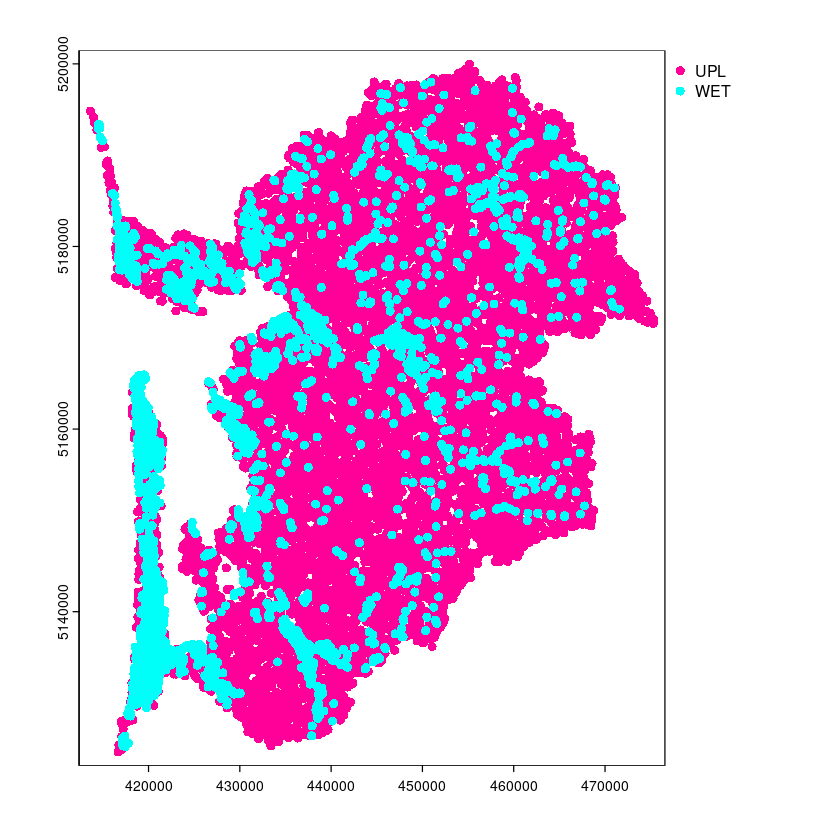

In [86]:
plot(vect(paste0(datapath, gsub(" ", "", paste0(values(wa_hucs[1]))), "_pts", ".gpkg")), "class")

Now apply the function to all WA HUCs 

- Only need to run once unless changes in point numbers need to be made

In [88]:
point_generator_func(WA_nwi, wa_hucs, datapath)

Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/WillapaBay_pts.gpkg does not support layer creation option ENCODING”
Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/LowerSkagit_pts.gpkg does not support layer creation option ENCODING”
Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/UpperSkagit_pts.gpkg does not support layer creation option ENCODING”
Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Message 6: dataset /home/ajs0428/WIP Testing/data/huc_data/points/Skykomish_pts.gpkg does not support layer creation option ENCODING”
Warning message in x@cpp$write(filename, layer, filetype, insert[1], overwrite[1], :
“GDAL Mess